In [1]:
#mount google drive when on google colab and set working directory

import sys
import os

if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/music_speech/')

working_dir = os.getcwd()
print(f'\nWorking directory: {working_dir}')


Working directory: /Users/kraehenb/music_speech


In [2]:
#check working directory and repo (git clone git@github.com:jkcas22/music_speech.git)

!{sys.executable} -m pip install gitpython
import git

repo = ['git@github.com:jkcas22/music_speech.git', 'https://github.com/jkcas22/music_speech.git']

if git.Repo(working_dir).remotes.origin.url in repo:
    print(f'\nRepository and working directory are fine.')
else:
    print(f'\nRepository: {git.Repo(working_dir).remotes.origin.url}')


Repository and working directory are fine.


In [3]:
#initialize environment, load modules/libraries

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
from scipy.signal import hann


#import python code from seperate files
from helpers.fourier_transform import load_wav, dft_logmag

2023-03-05 09:54:25.537756: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
music_dir = './data/music_wav'
music = [os.path.join(music_dir, file) for file in os.listdir(music_dir) if file.endswith('.wav')]

speech_dir = './data/speech_wav'
speech = [os.path.join(speech_dir, file) for file in os.listdir(speech_dir) if file.endswith('.wav')]

music_labels = np.zeros(len(music))
speech_labels = np.ones(len(speech))

In [5]:
speech_sounds = load_wav(speech)
music_sounds = load_wav(music)

# 22 kHz
# 16 Bit
# 30 s

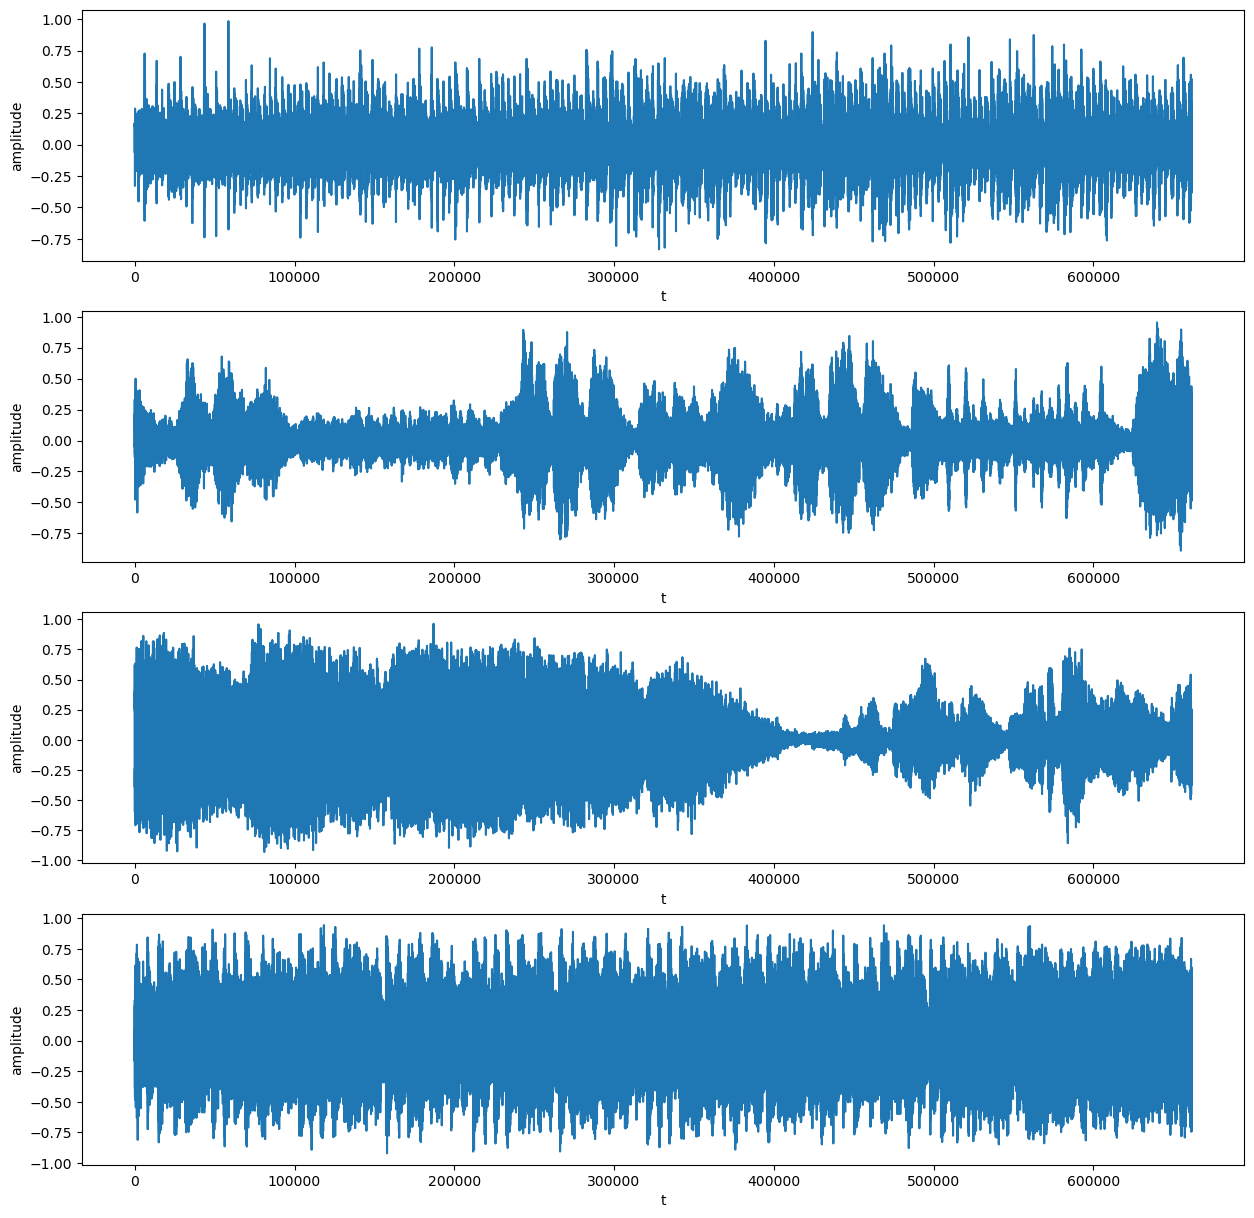

In [6]:
grid = (4,1)
n_grid = grid[0]*grid[1]
plt.figure(figsize=(15,15))
for i in range(n_grid):
    plt.subplot(grid[0],grid[1],i+1)
    plt.plot(music_sounds[i])
    plt.xlabel('t')
    plt.ylabel('amplitude')
plt.show()

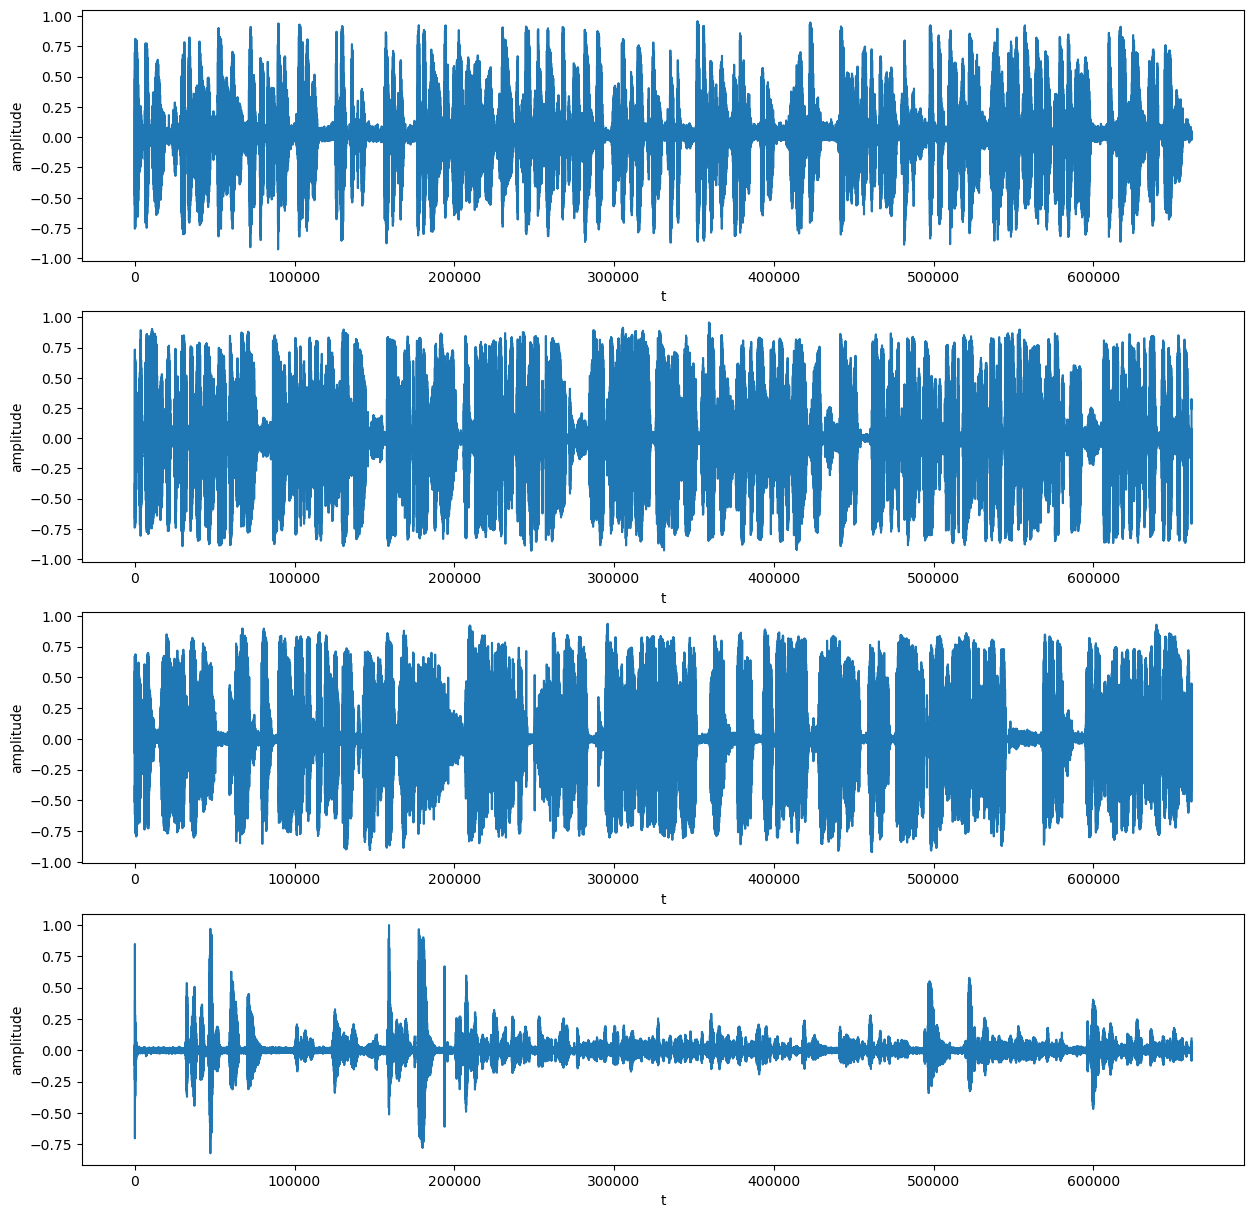

In [7]:
grid = (4,1)
n_grid = grid[0]*grid[1]
plt.figure(figsize=(15,15))
for i in range(n_grid):
    plt.subplot(grid[0],grid[1],i+1)
    plt.plot(speech_sounds[i])
    plt.xlabel('t')
    plt.ylabel('amplitude')
plt.show()

In [8]:
fft_step=256
fft_size=512
fft_chunks = len(speech_sounds[0])//fft_step

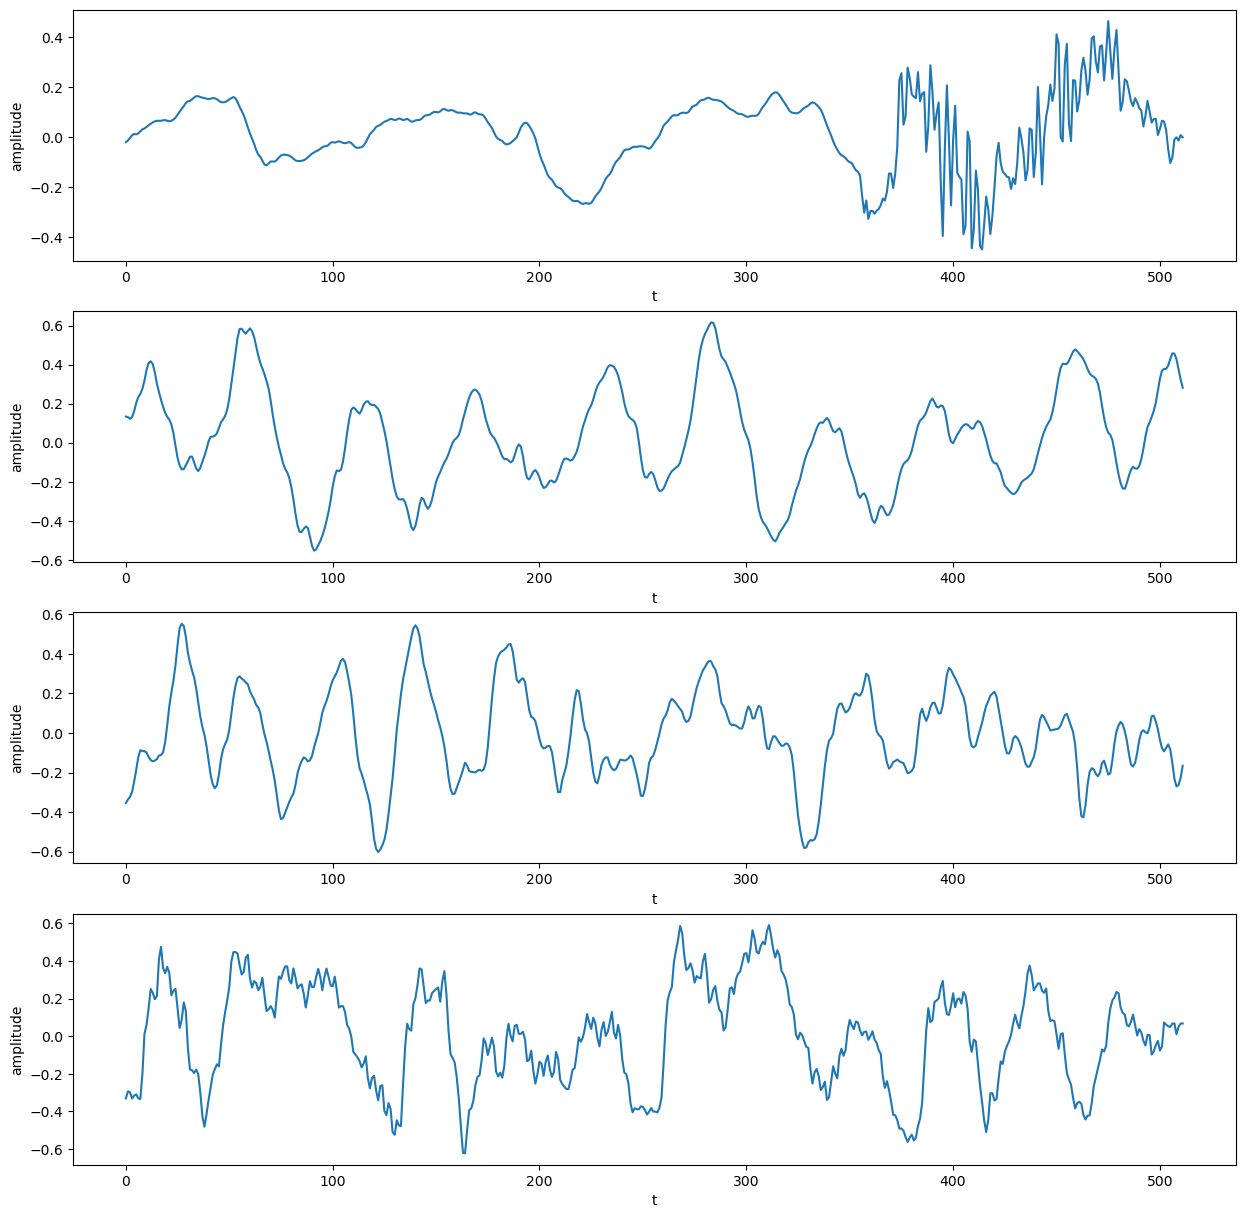

In [9]:
start_ft = 1000
start = start_ft*fft_step

grid = (4,1)
n_grid = grid[0]*grid[1]
plt.figure(figsize=(15,15))
for i in range(n_grid):
    plt.subplot(grid[0],grid[1],i+1)
    plt.plot(music_sounds[i][start:start+fft_size])
    plt.xlabel('t')
    plt.ylabel('amplitude')
plt.show()

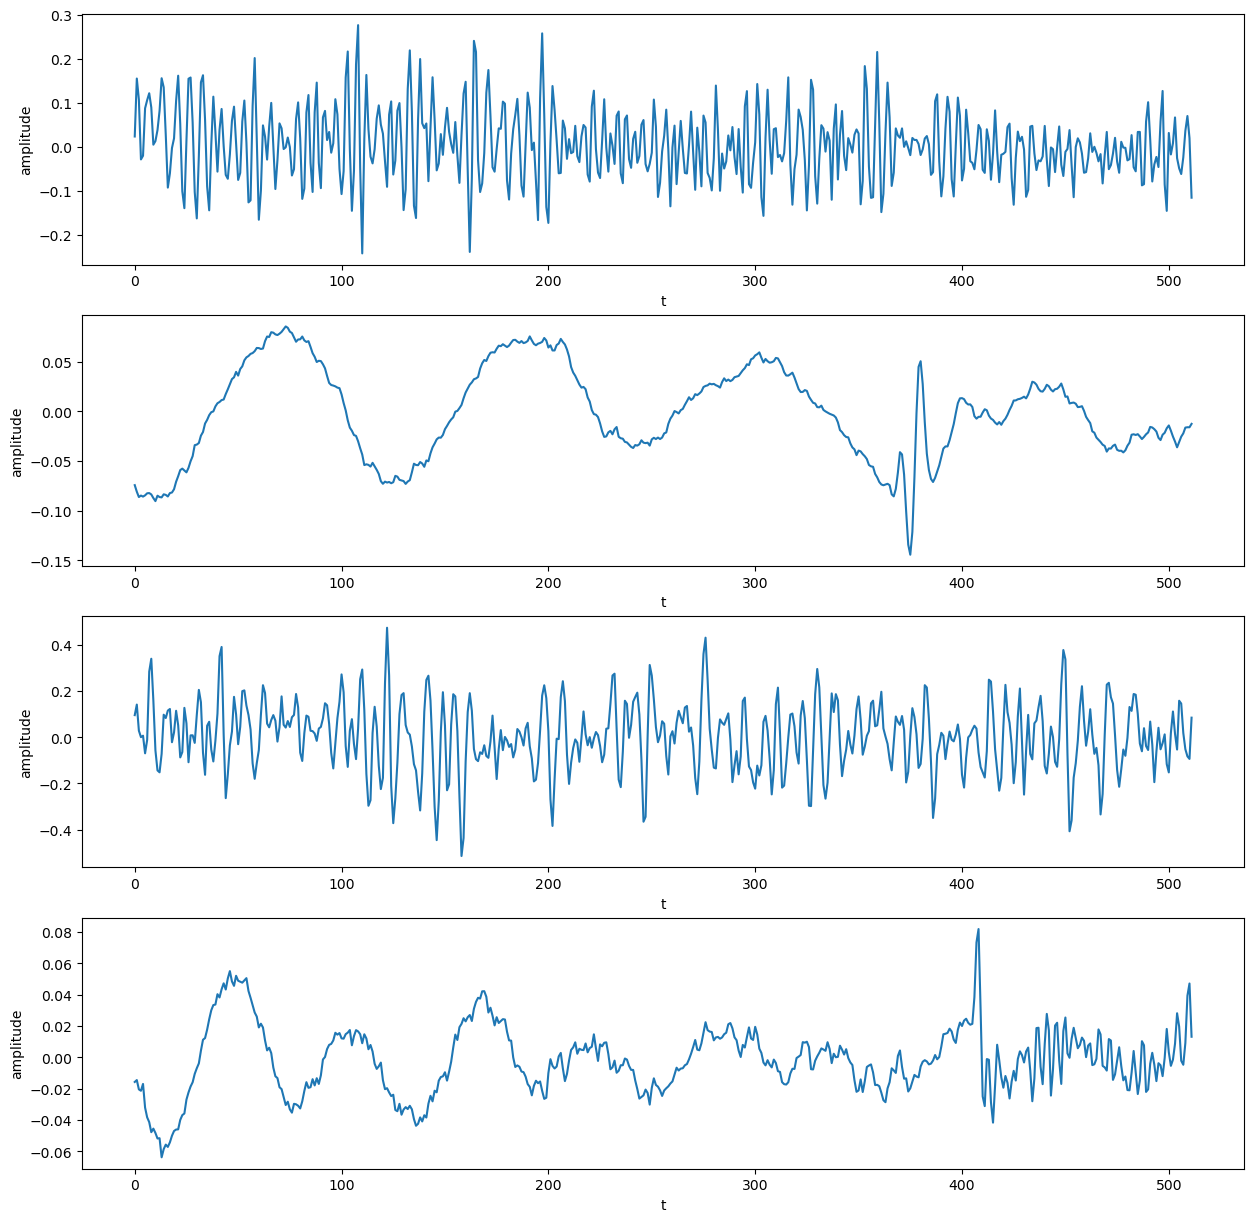

In [10]:
grid = (4,1)
n_grid = grid[0]*grid[1]
plt.figure(figsize=(15,15))
for i in range(n_grid):
    plt.subplot(grid[0],grid[1],i+1)
    plt.plot(speech_sounds[i][start:start+fft_size])
    plt.xlabel('t')
    plt.ylabel('amplitude')
plt.show()

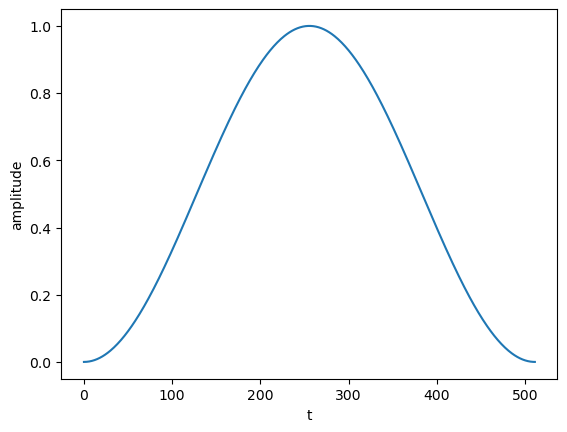

In [11]:
hann_win = hann(fft_size)

plt.plot(hann_win)
plt.xlabel('t')
plt.ylabel('amplitude')
plt.show()

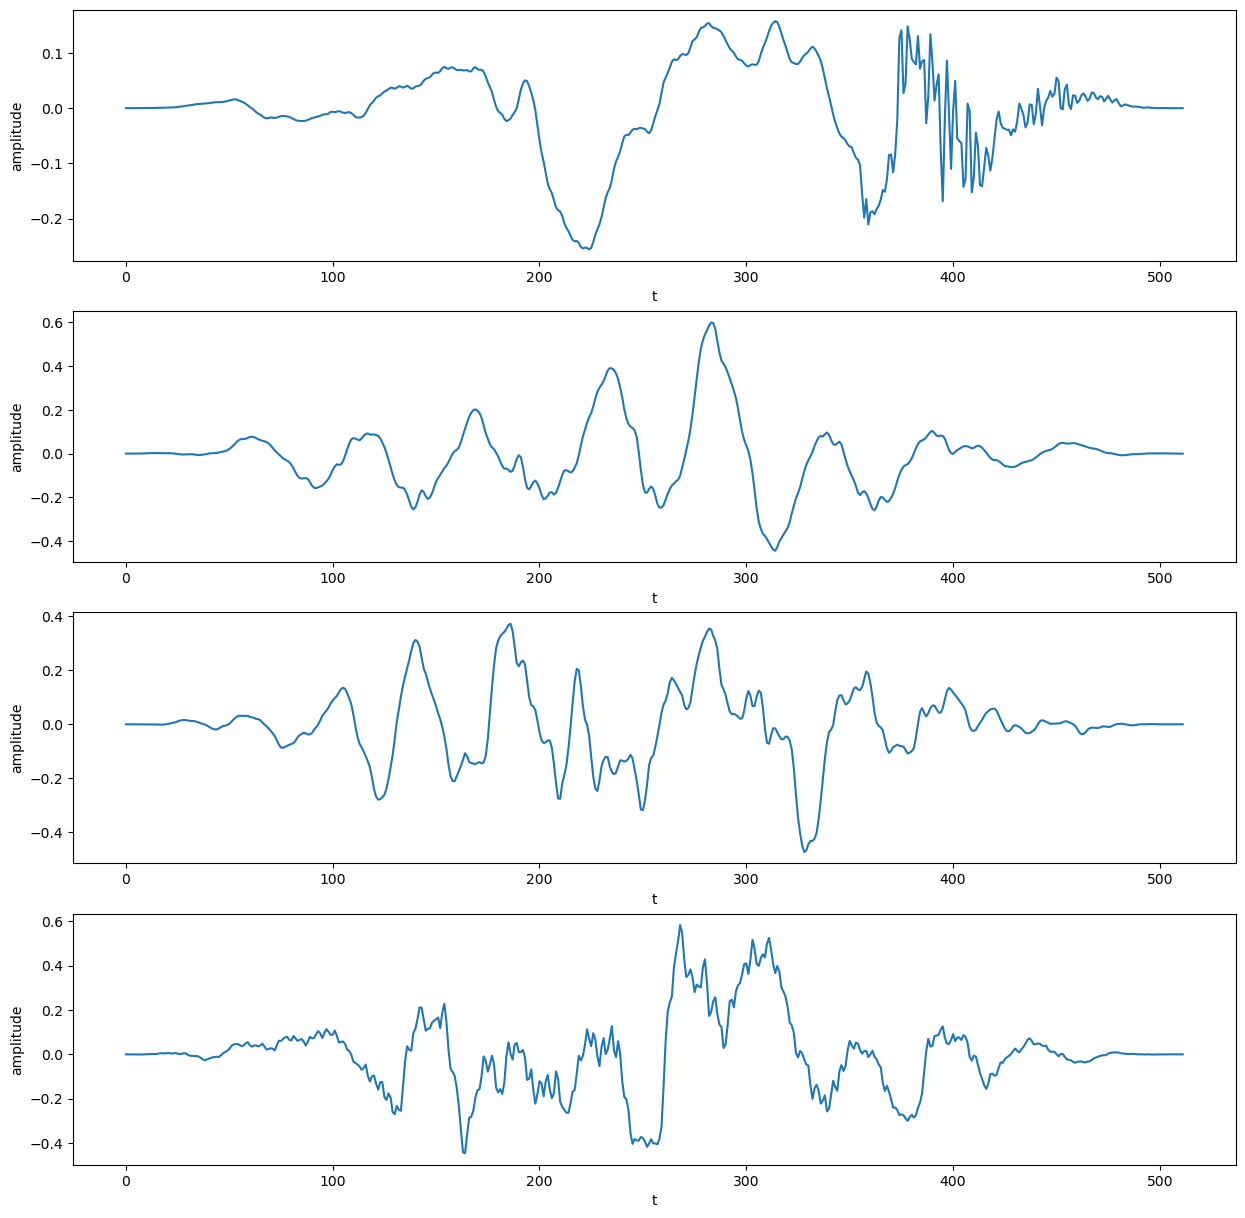

In [12]:
grid = (4,1)
n_grid = grid[0]*grid[1]
plt.figure(figsize=(15,15))
for i in range(n_grid):
    plt.subplot(grid[0],grid[1],i+1)
    plt.plot(music_sounds[i][start:start+fft_size]*hann_win)
    plt.xlabel('t')
    plt.ylabel('amplitude')
plt.show()

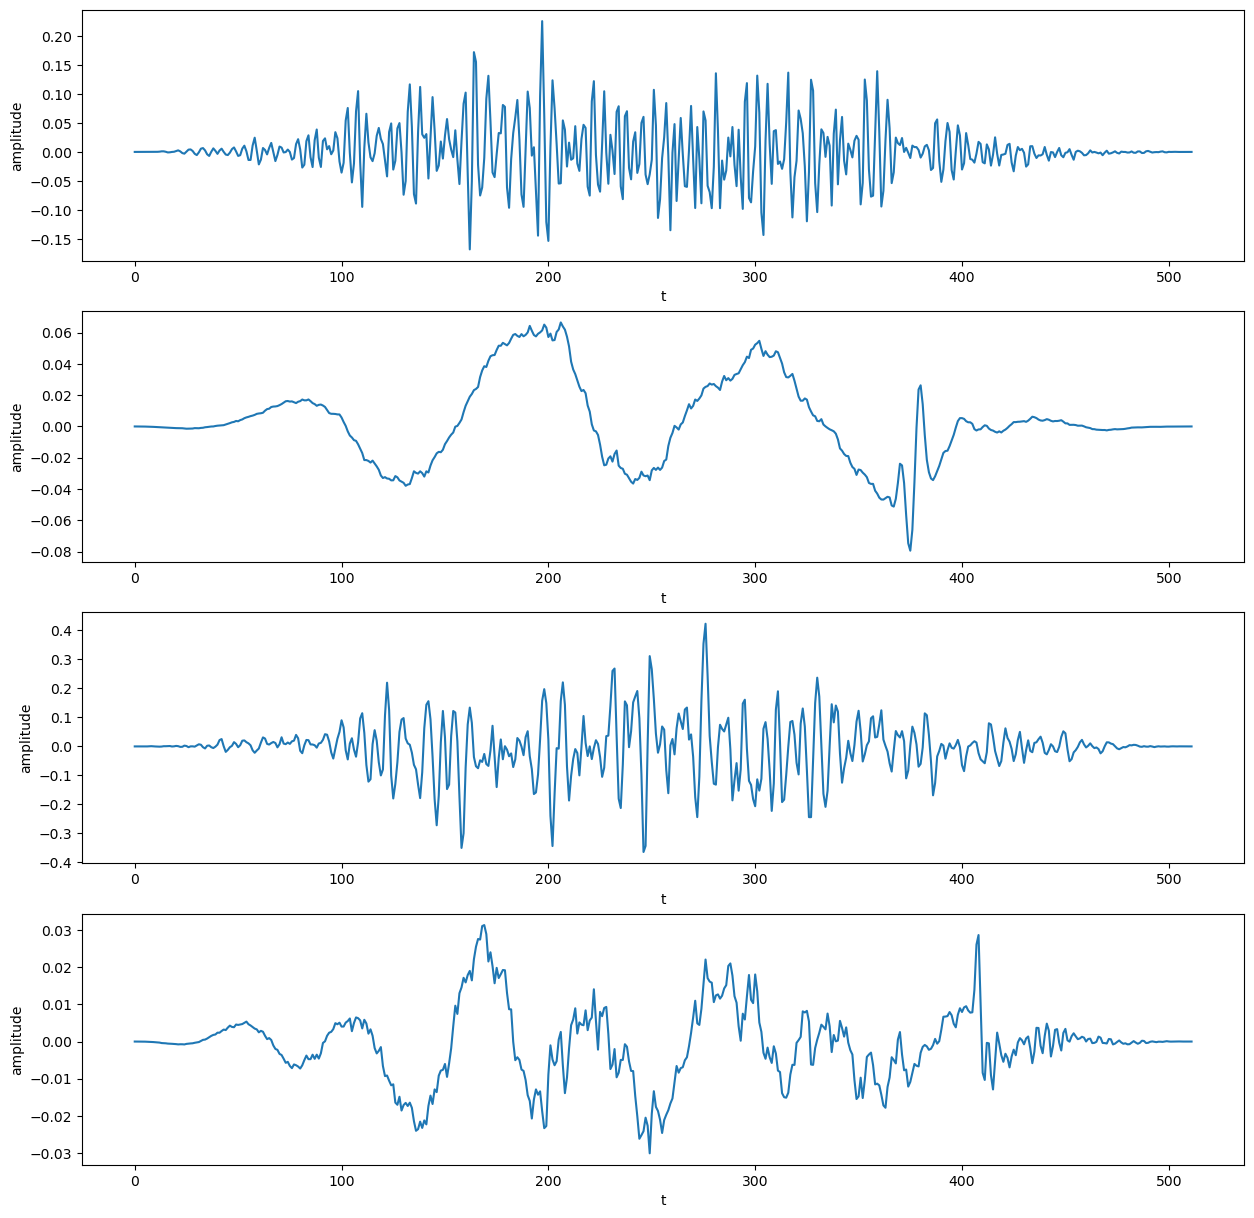

In [13]:
grid = (4,1)
n_grid = grid[0]*grid[1]
plt.figure(figsize=(15,15))
for i in range(n_grid):
    plt.subplot(grid[0],grid[1],i+1)
    plt.plot(speech_sounds[i][start:start+fft_size]*hann_win)
    plt.xlabel('t')
    plt.ylabel('amplitude')
plt.show()

In [14]:
speech_logmag = dft_logmag(speech_sounds,fft_chunks,fft_step,fft_size)
music_logmag = dft_logmag(music_sounds,fft_chunks,fft_step,fft_size)

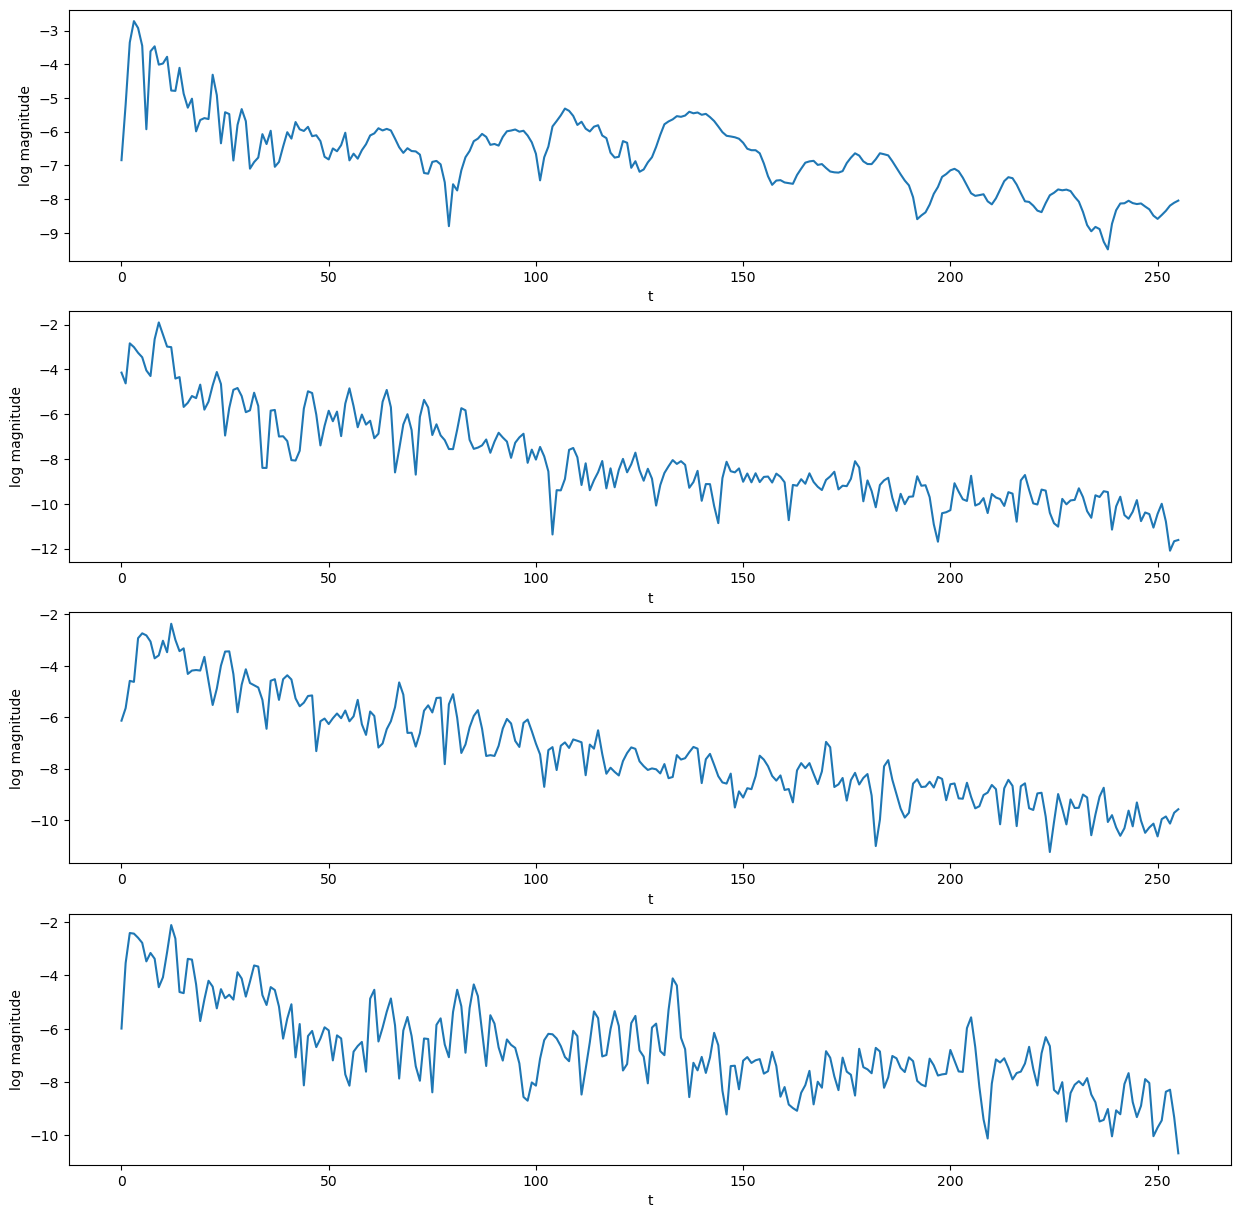

In [15]:
grid = (4,1)
n_grid = grid[0]*grid[1]
plt.figure(figsize=(15,15))
for i in range(n_grid):
    plt.subplot(grid[0],grid[1],i+1)
    plt.plot(music_logmag[i][start_ft])
    plt.xlabel('t')
    plt.ylabel('log magnitude')
plt.show()

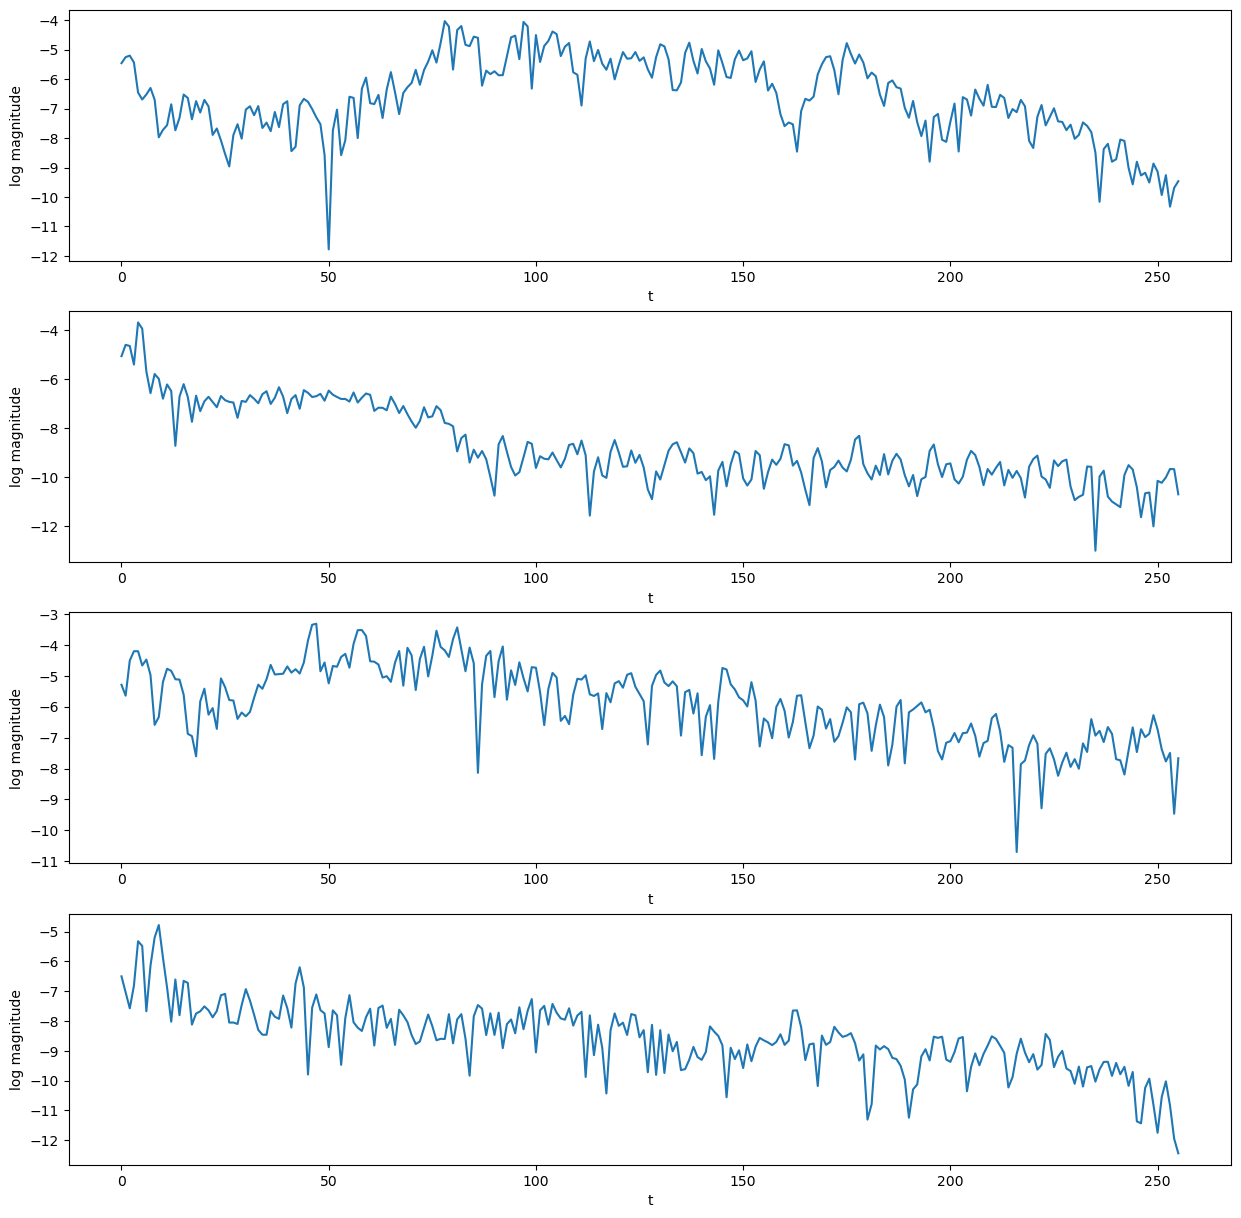

In [16]:
grid = (4,1)
n_grid = grid[0]*grid[1]
plt.figure(figsize=(15,15))
for i in range(n_grid):
    plt.subplot(grid[0],grid[1],i+1)
    plt.plot(speech_logmag[i][start_ft])
    plt.xlabel('t')
    plt.ylabel('log magnitude')
plt.show()

In [17]:
patch_size = 32

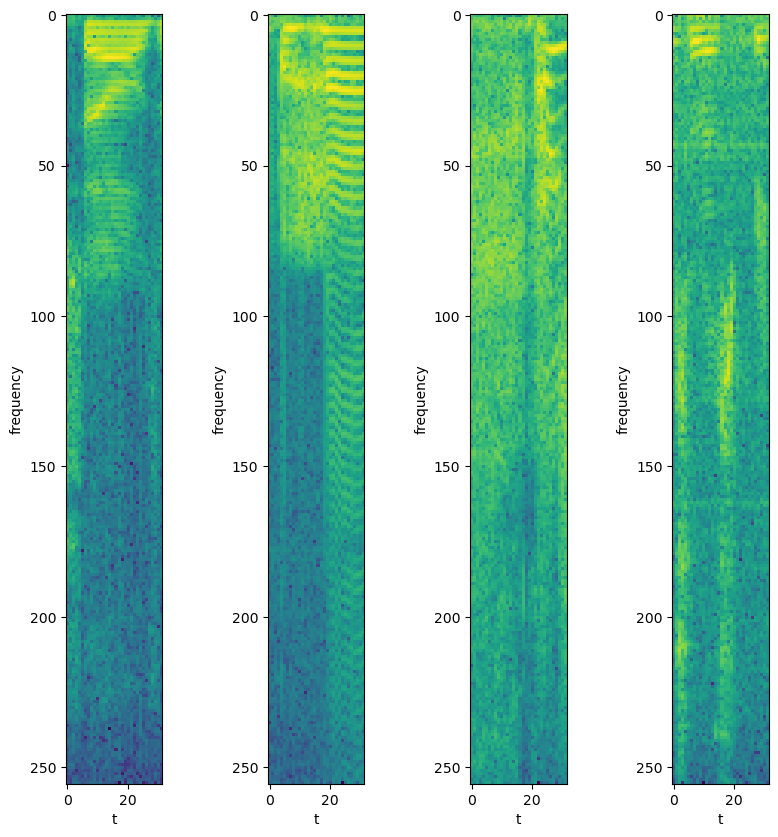

In [18]:
grid = (1,4)
n_grid = grid[0]*grid[1]
plt.figure(figsize=(10,10))
for i in range(n_grid):
    plt.subplot(grid[0],grid[1],i+1)
    plt.imshow(speech_logmag[i][start_ft:start_ft+patch_size].T)
    plt.xlabel('t')
    plt.ylabel('frequency')
plt.show()

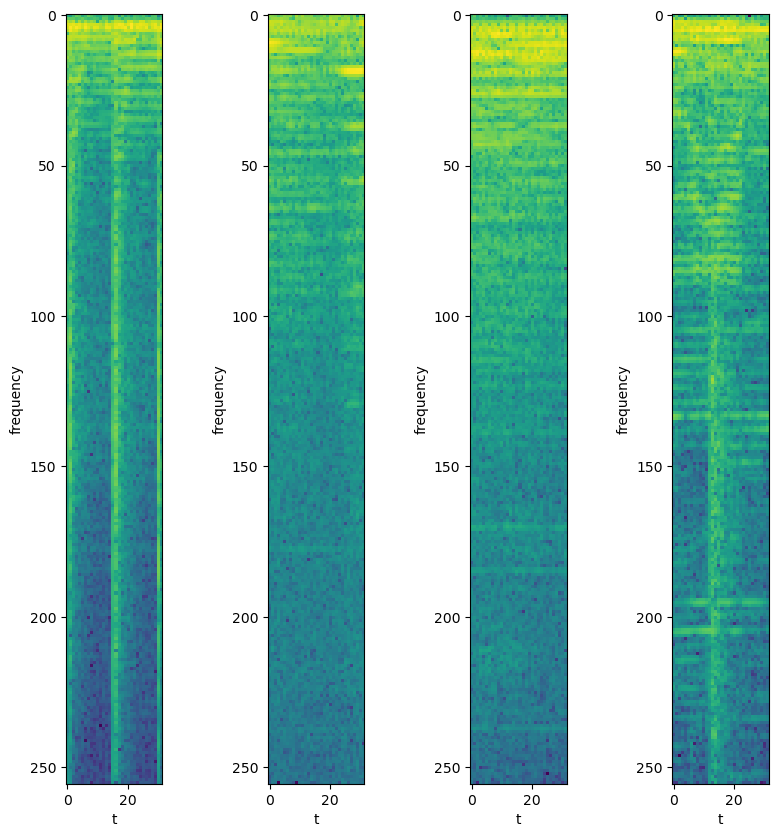

In [19]:
grid = (1,4)
n_grid = grid[0]*grid[1]
plt.figure(figsize=(10,10))
for i in range(n_grid):
    plt.subplot(grid[0],grid[1],i+1)
    plt.imshow(music_logmag[i][start_ft:start_ft+patch_size].T)
    plt.xlabel('t')
    plt.ylabel('frequency')
plt.show()

In [26]:
sounds_logmag = np.concatenate((music_logmag,speech_logmag))
sounds_labels = np.concatenate((music_labels, speech_labels))

In [28]:
patch_step = 1

def ds_window(sound, label):
    n, m = sound.shape
    labels = np.ones(n)*label
    sound = np.c_[sound,labels]
    ds = tf.data.Dataset.from_tensor_slices(sound)
    ds = ds.window(size=patch_size,shift=patch_step,drop_remainder=True)
    return ds

def ds_patches(sounds, labels):
    ds = ds_window(sounds[0],labels[0])
    for sound, label in zip(sounds[1:],labels[1:]): ds = ds.concatenate(ds_window(sound,label))
    ds = ds.flat_map(lambda x: x.batch(patch_size))
    ds = ds.map(lambda x: (x[:patch_size,:-1], x[0,-1]))
    return ds.batch(1)

sounds_ds = ds_patches(sounds_logmag, sounds_labels)

n_patches = 326656
# for e in sounds_ds: n_patches+=1
# print(n_patches)

In [ ]:
sounds_ds = sounds_ds.shuffle(n_patches).prefetch(1)

In [ ]:
n = 10
labels =[]
for i, (sound, label) in enumerate(sounds_ds.take(n)):
    labels+=[int(label.numpy()[0])]
    plt.subplot(1,n,i+1)
    plt.imshow(sound.numpy()[0].T)
    if i == 0:
        plt.xlabel('t')
        plt.ylabel('frequency')
print(f"Labels: {labels}")
plt.show()


2023-03-05 09:52:15.013714: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 30299 of 163328
2023-03-05 09:52:25.013939: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 48377 of 163328
2023-03-05 09:52:35.013752: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 73809 of 163328
2023-03-05 09:52:45.013891: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 97130 of 163328
2023-03-05 09:52:55.014564: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 122314 of 163328
2023-03-05 09:53:05.013791: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 147816 of 163328
